In [2]:
import os
os.chdir('../')  # Moving up one directory to the root
import sys
import tensorflow as tf
import numpy as np
import random
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from models.sentiment_model import EnhancedDistilBertForSentiment
from config.model_config import ModelConfig
from main import SentimentAnalyzer
from utils.analysis import SentimentAnalysisVisualizer

2024-12-09 10:37:49.898366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Add project root to Python path
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

In [29]:
# 1. First create the analyzer
analyzer = SentimentAnalyzer()

# 2. Process the data - this will set up train, val, and test sets
analyzer.process_data()

# Reduce test set to 500 examples while maintaining class balance
analyzer.test_texts = analyzer.test_texts[:500]
analyzer.test_labels = {k: v[:500] for k, v in analyzer.test_labels.items()}

# 3. loading the previously saved model:
epoch = 2  # or whatever epoch you saved
model_dir = os.path.join(os.getcwd(), 'saved_models')
loaded_model, training_history = analyzer.load_saved_model(epoch, model_dir)


# 4. Now you can run your evaluation
print("\nEvaluating model on test set...")
test_predictions = []
print(f"Processing {len(analyzer.test_texts)} test examples...")

for i, text in enumerate(analyzer.test_texts):
    prediction = analyzer.predict(text)
    test_predictions.append(prediction)
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{len(analyzer.test_texts)} examples")

Training set size: 10500 (70.0%)
Validation set size: 3000 (20.0%)
Test set size: 1500 (10.0%)
Loading model from directory: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models
Loaded model configuration and training history
Initialized tokenizer


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Initialized model architecture
Loaded model weights successfully
Model compiled successfully

Model loaded successfully!
Original training epochs: 2
Final validation accuracy: 0.7343
Prediction: {'sentiment': {'negative': 0.505087673664093, 'neutral': 0.26205313205718994, 'positive': 0.23285923898220062}, 'predicted': 'negative'}

Evaluating model on test set...
Processing 500 test examples...
Processed 100/500 examples
Processed 200/500 examples
Processed 300/500 examples
Processed 400/500 examples
Processed 500/500 examples


In [59]:
# NEGATIVE
text = "bad experience :(( never going back again"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")

# NEGATIVE WITH SARCASM
text = "perfect place to waste your money"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")


# NEGATIVE WITH NEGATION
text = "not a good place to shop"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")

# MULTIPOLAR NEGATIVE
text = "good vibe but not a very good food, not satisfied though"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")


# NEUTRAL
text = "not a good place to shop BUT YOU CAN SEE LOTS OF CELEBRITIES THERE !!! "
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")

#POSITIVE
text = "very satisfied with the food "
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")

print("NEGATIVE WITH SARCASM\n\n\n")

text = "Oh great, another 45-minute wait for a 'world-famous' burger that's basically a glorified fast food patty. The ambiance of crying babies and sticky tables really enhanced the experience. Five stars for teaching me the true meaning of patience! 🙄"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")
# NEGATIVE WITH SARCASM
text = "Wow, thanks SO much for the amazing service! I just love waiting 20 minutes for water while watching the staff scroll through their phones. The lukewarm food was a nice touch - who needs hot meals anyway? 😒"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")
# NEGATIVE WITH SARCASM
text = "Absolutely brilliant idea to put exactly three pieces of chicken in my $25 'signature' salad. I'm sure those tiny cubes of meat are made of gold to justify the price. And thank you for the wilted lettuce, really adds to that authentic experience! 🫤"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")
# NEGATIVE WITH SARCASM
text = "Just what I needed after a long day - getting my order wrong three times in a row! I mean, who wouldn't want to sample the entire menu through a series of mistakes? The confused looks from the staff were priceless. Best entertainment ever! 😤"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")
# NEGATIVE WITH SARCASM
text = "Suuure, I totally love paying premium prices for microwaved food. The frozen vegetables were a nice touch - still frozen in the middle, just how I like them! And the waiter's attitude? chef's kiss Perfect way to make customers feel special... 🙃"
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")


print("NEGATIVE WITH NEGATION \n\n\n")
text = "The food isn't bad, but it's not great either. I couldn't find anything special about their signature dishes and won't be rushing back. The service wasn't particularly attentive, and the prices definitely don't match the quality. "
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")
text = "This restaurant has never impressed me with their flavors. The spices weren't balanced, and the sauce didn't complement the dish at all. I'm not saying it's terrible, but I haven't had a memorable meal here. "
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")
text = "The ambiance wasn't what I expected. The music wasn't too loud, but the lighting wasn't right for a fine dining experience. The staff didn't seem to know the menu well, and they couldn't answer basic questions about ingredients. "
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")
text = "Don't waste your time with their special menu items. The chef's recommendations weren't worth the premium price, and the portions weren't filling at all. The dessert menu didn't have any unique options. "
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")
text = "I can't believe they call this authentic Italian food. The pasta wasn't fresh, the sauce wasn't homemade, and they don't even serve complimentary bread. The wine list wasn't extensive, and the server couldn't make any good recommendations. "
prediction = analyzer.predict(text)
print(f"Prediction: {prediction}")


Prediction: {'sentiment': {'negative': 0.505087673664093, 'neutral': 0.26205313205718994, 'positive': 0.23285923898220062}, 'predicted': 'negative'}
Prediction: {'sentiment': {'negative': 0.2797688841819763, 'neutral': 0.3246217966079712, 'positive': 0.3956093490123749}, 'predicted': 'positive'}
Prediction: {'sentiment': {'negative': 0.41141343116760254, 'neutral': 0.33981865644454956, 'positive': 0.2487679123878479}, 'predicted': 'negative'}
Prediction: {'sentiment': {'negative': 0.28625351190567017, 'neutral': 0.47267258167266846, 'positive': 0.24107392132282257}, 'predicted': 'neutral'}
Prediction: {'sentiment': {'negative': 0.3003727197647095, 'neutral': 0.4516547918319702, 'positive': 0.2479725480079651}, 'predicted': 'neutral'}
Prediction: {'sentiment': {'negative': 0.2525348365306854, 'neutral': 0.3372531533241272, 'positive': 0.4102119505405426}, 'predicted': 'positive'}
NEGATIVE WITH SARCASM



Prediction: {'sentiment': {'negative': 0.22332030534744263, 'neutral': 0.2395599335


=== Evaluation Metrics ===

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.83      0.80       163
     Neutral       0.60      0.66      0.63       148
    Positive       0.90      0.78      0.84       189

    accuracy                           0.76       500
   macro avg       0.76      0.76      0.76       500
weighted avg       0.77      0.76      0.76       500



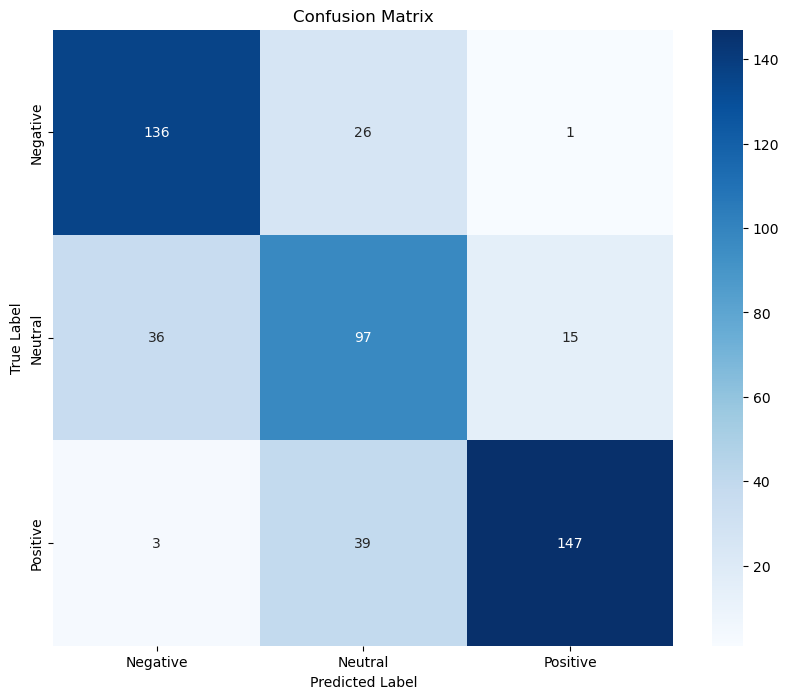


Overall Accuracy: 0.7600
Negative Class Accuracy: 0.8344
Neutral Class Accuracy: 0.6554
Positive Class Accuracy: 0.7778

Average Prediction Confidence: 0.4883

Prediction Distribution:
Negative: 175 (35.00%)
Neutral: 162 (32.40%)
Positive: 163 (32.60%)


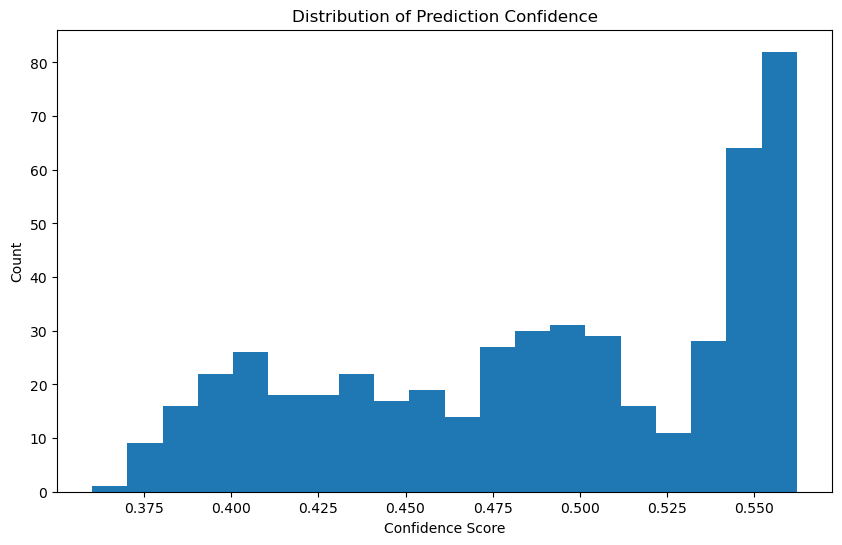

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels and predicted labels from existing data
true_labels = analyzer.test_labels['sentiment'][:500]  # since we used 500 samples
predicted_labels = []

# Convert existing predictions to labels
for pred in test_predictions:
    predicted_label = ['negative', 'neutral', 'positive'].index(pred['predicted'])
    predicted_labels.append(predicted_label)

# Now calculate all metrics
print("\n=== Evaluation Metrics ===")

# Classification Report
print("\nClassification Report:")
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate additional metrics
accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Class-wise accuracy
for i, class_name in enumerate(target_names):
    class_mask = np.array(true_labels) == i
    class_accuracy = np.mean(np.array(predicted_labels)[class_mask] == i)
    print(f"{class_name} Class Accuracy: {class_accuracy:.4f}")

# Analyze prediction confidence
confidence_scores = []
for pred in test_predictions:
    confidence_scores.append(max(pred['sentiment'].values()))

avg_confidence = np.mean(confidence_scores)
print(f"\nAverage Prediction Confidence: {avg_confidence:.4f}")

# Distribution of predictions
print("\nPrediction Distribution:")
for label, count in zip(*np.unique(predicted_labels, return_counts=True)):
    print(f"{target_names[label]}: {count} ({count/len(predicted_labels)*100:.2f}%)")

# Plot confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=20)
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.show()

/Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/utils/analysis.py:208: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/utils/analysis.py:217: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


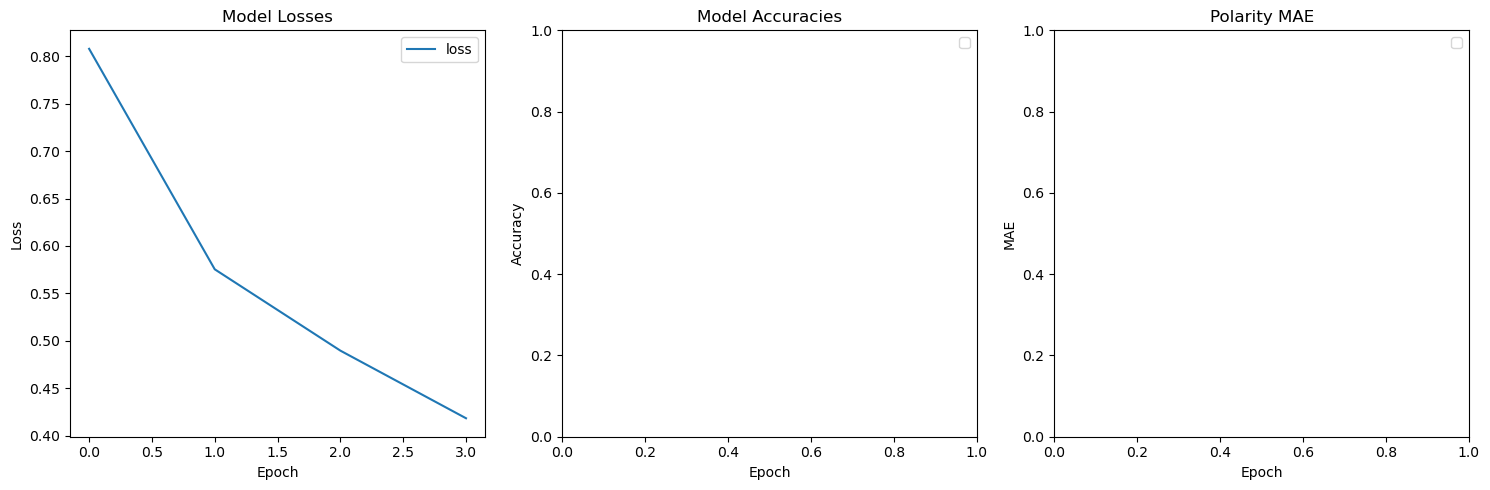


Final Training Metrics:
loss: 0.4185
val_loss: 0.6780
accuracy: 0.8442
val_accuracy: 0.7343


In [13]:
# Visualize training history
visualizer = SentimentAnalysisVisualizer()
visualizer.visualize_training_history(training_history)